<a href="https://colab.research.google.com/github/kristina-skoptsova/diplom/blob/main/diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = '/content/dataset_muiv.csv'
df = pd.read_csv(file)
df = pd.DataFrame(df)
df

,Направление,Год поступления,Количество поступивших,Сумма баллов,Сумма баллов за ВИ,Кол-во баллов за ИД,Возраст,Регион рождения,Уровень безработицы,Доля женщин,Доля преимущественного права,Доля наличия договора
0,1,1908,11,180.909091,76.090909,83.454545,25.636364,76.090909,33.727273,0.454545,0.181818,0.000000
1,1,1909,11,181.636364,69.272727,82.727273,24.545455,69.272727,29.909091,0.214286,0.000000,0.214286
2,1,1910,11,173.636364,63.181818,83.181818,23.820205,63.181818,27.000000,0.210526,0.105263,0.052632
3,1,1911,11,184.181818,72.454545,82.909091,26.913137,72.454545,32.636364,0.312500,0.125000,0.000000
4,1,1912,11,193.454545,69.545455,82.363636,26.636364,69.545455,29.909091,0.113636,0.045455,0.068182
...,...,...,...,...,...,...,...,...,...,...,...,...
5962,51,2020,19,183.210526,61.842105,80.105263,26.899422,61.842105,17.052632,0.333333,0.041667,0.291667
5963,51,2021,20,192.150000,70.600000,75.750000,26.301113,70.600000,17.850000,0.225806,0.032258,0.096774
5964,51,2022,20,181.950000,62.550000,77.050000,26.702225,62.550000,16.200000,0.916667,0.083333,0.166667
5965,51,2023,20,179.050000,69.900000,80.500000,24.903338,69.900000,18.800000,0.666667,0.000000,0.333333


In [3]:
columns_to_drop = ["Уровень безработицы", "Регион рождения", "Доля наличия договора"]
df = df.drop(columns=columns_to_drop)

In [7]:
from sklearn.preprocessing import RobustScaler

# Колонки, которые не нужно масштабировать
exclude_columns = ['Направление', 'Год поступления', 'Количество поступивших']

# Колонки для масштабирования
columns_to_scale = [col for col in df.columns if col not in exclude_columns]

# Применение RobustScaler
scaler = RobustScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df

,Направление,Год поступления,Количество поступивших,Сумма баллов,Сумма баллов за ВИ,Кол-во баллов за ИД,Возраст,Доля женщин,Доля преимущественного права
0,1,1908,11,-0.396459,1.433206,1.321374,-0.302991,0.038625,0.957492
1,1,1909,11,-0.317483,-0.171129,1.074900,-1.201778,-0.599383,-0.810185
2,1,1910,11,-1.186219,-1.604335,1.228946,-1.799302,-0.609366,0.213207
3,1,1911,11,-0.041067,0.577561,1.136518,0.748927,-0.338575,0.405093
4,1,1912,11,0.965876,-0.106956,0.951663,0.520897,-0.866657,-0.368266
...,...,...,...,...,...,...,...,...,...
5962,51,2020,19,-0.146542,-1.919573,0.186297,0.737627,-0.283253,-0.405093
5963,51,2021,20,0.824213,0.141181,-1.289708,0.244688,-0.568790,-0.496565
5964,51,2022,20,-0.283425,-1.753003,-0.849137,0.575160,1.265785,0.000000
5965,51,2023,20,-0.598341,-0.023530,0.320074,-0.906922,0.601912,-0.810185


In [8]:
X = df.drop(columns=['Количество поступивших'])
y = df['Количество поступивших']

In [9]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  RobustScaler

# Функция для создания последовательностей данных
def create_sequences(data, window_size):
    inputs, outputs, groups = [], [], []
    for direction in data['Направление'].unique():
        dir_data = data[data['Направление'] == direction].sort_values('Год поступления')
        for i in range(len(dir_data) - window_size):
            seq = dir_data.iloc[i:i+window_size].drop(['Направление', 'Год поступления', 'Количество поступивших'], axis=1).values
            target = dir_data.iloc[i+window_size]['Количество поступивших']
            direction_label = dir_data.iloc[i+window_size]['Направление']  # Направление для следующего шага
            inputs.append(seq)
            outputs.append(target)
            groups.append(direction_label)
    return np.array(inputs), np.array(outputs), np.array(groups)

# Создание последовательностей
YEARS_SIZE = 3
X, y, direction_labels = create_sequences(df, YEARS_SIZE)

# Нормализация y
y_scaler = RobustScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test, direction_train, direction_test = train_test_split(
    X, y, direction_labels, test_size=0.2, random_state=42)

# Рассчитываются веса только для тренировочной выборки
unique_directions, direction_counts_train = np.unique(direction_train, return_counts=True)
direction_weights_train = {direction: 1.0 / count for direction, count in zip(unique_directions, direction_counts_train)}

# Применение весов к данным
sample_weights = df['Направление'].map(direction_weights_train).values

# Ограничение веса для тренировочной выборки
train_sample_weights = sample_weights[:len(y_train)]

# Архитектура модели
model_lstm = Sequential([
    Input(shape=(YEARS_SIZE, X.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])

# Компиляция модели
model_lstm.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Обучение модели
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    sample_weight=train_sample_weights,  # Использование веса
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Оценка модели на тестовой выборке
test_loss, test_mae = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0062 - mae: 0.5641 - val_loss: 0.0042 - val_mae: 0.3856
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0042 - mae: 0.3789 - val_loss: 0.0037 - val_mae: 0.3387
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039 - mae: 0.3522 - val_loss: 0.0035 - val_mae: 0.3261
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - mae: 0.3362 - val_loss: 0.0034 - val_mae: 0.3145
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - mae: 0.3305 - val_loss: 0.0035 - val_mae: 0.3206
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - mae: 0.3330 - val_loss: 0.0033 - val_mae: 0.3086
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - mae: 0.3203 - val_loss: 0.0033 - val_mae: 0.3035
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - mae: 0.3159 - val_loss: 0.0033 - val_mae: 0.3008
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - l

In [10]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.1 MB/s eta 0:00:00


In [ ]:
import optuna
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from sklearn.model_selection import train_test_split

# Функция для создания последовательностей данных
def create_sequences(data, window_size):
    inputs, outputs, groups = [], [], []
    for direction in data['Направление'].unique():
        dir_data = data[data['Направление'] == direction].sort_values('Год поступления')
        for i in range(len(dir_data) - window_size):
            seq = dir_data.iloc[i:i+window_size].drop(['Направление', 'Год поступления', 'Количество поступивших'], axis=1).values
            target = dir_data.iloc[i+window_size]['Количество поступивших']
            direction_label = dir_data.iloc[i+window_size]['Направление']  # Направление для следующего шага
            inputs.append(seq)
            outputs.append(target)
            groups.append(direction_label)
    return np.array(inputs), np.array(outputs), np.array(groups)

# Создание последовательностей
YEARS_SIZE = 5
X, y, direction_labels = create_sequences(df, YEARS_SIZE)

# Нормализация целевой переменной
y_scaler = RobustScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test, direction_train, direction_test = train_test_split(
    X, y, direction_labels, test_size=0.2, random_state=42)

# Рассчитываются веса только для тренировочной выборки
unique_directions, direction_counts_train = np.unique(direction_train, return_counts=True)
direction_weights_train = {direction: 1.0 / count for direction, count in zip(unique_directions, direction_counts_train)}

# Применение весов к данным
sample_weights = df['Направление'].map(direction_weights_train).values

# Ограничение веса для тренировочной выборки
train_sample_weights = sample_weights[:len(y_train)]

# Функция для оптимизации
def objective(trial):
    units = trial.suggest_categorical('units', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.1, 0.3)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [50, 100])

    model = Sequential([
        Input(shape=(YEARS_SIZE, X.shape[2])),
        LSTM(units, return_sequences=True),
        Dropout(dropout),
        LSTM(units),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        sample_weight=train_sample_weights,  # Использование весов только для тренировочной выборки
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=0
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

# Запуск оптимизации
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Лучшие параметры:", study.best_params)
print("Лучшее значение функции потерь:", study.best_value)

[I 2025-02-14 12:45:00,991] A new study created in memory with name: no-name-1928bc54-7511-4bea-a799-817bc95ef90f
<ipython-input-7-eb43177ad36e>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2025-02-14 12:46:08,686] Trial 0 finished with value: 0.08152828365564346 and parameters: {'units': 128, 'dropout': 0.29744228653792726, 'learning_rate': 0.0004701508779560315, 'batch_size': 64, 'epochs': 100}. Best is trial 0 with value: 0.08152828365564346.
[I 2025-02-14 12:47:13,843] Trial 1 finished with value: 0.07052230834960938 and parameters: {'units': 128, 'dropout': 0.23283026226206147, 'learning_rate': 0.0015078992861602273, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.07052230834960938.
[I 2025-02-14 12:49:10,850] Trial 2 finished with

Лучшие параметры: {'units': 64, 'dropout': 0.10628690630235599, 'learning_rate': 0.012925524750519703, 'batch_size': 64, 'epochs': 100}
Лучшее значение функции потерь: 0.05137728154659271


In [25]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Функция для создания последовательностей данных
def create_sequences(data, window_size):
    inputs, outputs, groups = [], [], []
    for direction in data['Направление'].unique():
        dir_data = data[data['Направление'] == direction].sort_values('Год поступления')
        for i in range(len(dir_data) - window_size):
            seq = dir_data.iloc[i:i+window_size].drop(['Направление', 'Год поступления', 'Количество поступивших'], axis=1).values
            target = dir_data.iloc[i+window_size]['Количество поступивших']
            direction_label = dir_data.iloc[i+window_size]['Направление']  # Направление для следующего шага
            inputs.append(seq)
            outputs.append(target)
            groups.append(direction_label)
    return np.array(inputs), np.array(outputs), np.array(groups)

# Создание последовательностей
YEARS_SIZE = 5
X, y, direction_labels = create_sequences(df, YEARS_SIZE)

# Нормализация целевой переменной
y_scaler = RobustScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test, direction_train, direction_test = train_test_split(
    X, y, direction_labels, test_size=0.2, random_state=42)

# Рассчитываются веса только для тренировочной выборки
unique_directions, direction_counts_train = np.unique(direction_train, return_counts=True)
direction_weights_train = {direction: 1.0 / count for direction, count in zip(unique_directions, direction_counts_train)}

# Применение весов к данным
sample_weights = df['Направление'].map(direction_weights_train).values

# Ограничение веса для тренировочной выборки
train_sample_weights = sample_weights[:len(y_train)]

# Архитектура модели
model_lstm = Sequential([
    Input(shape=(YEARS_SIZE, X.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.1),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])

# Компиляция модели
model_lstm.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Ранняя остановка при переобучении
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True  # Восстановление весов модели с лучшим результатом
)

# Обучение модели
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    sample_weight=train_sample_weights,  # Использование веса
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Оценка модели на тестовой выборке
test_loss, test_mae = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0059 - mae: 0.5280 - val_loss: 0.0034 - val_mae: 0.3055
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.3045 - val_loss: 0.0031 - val_mae: 0.2810
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.2838 - val_loss: 0.0028 - val_mae: 0.2585
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - mae: 0.2678 - val_loss: 0.0028 - val_mae: 0.2506
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.2576 - val_loss: 0.0027 - val_mae: 0.2492
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.2552 - val_loss: 0.0027 - val_mae: 0.2426
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.2535 - val_loss: 0.0026 - val_mae: 0.2392
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - mae: 0.2460 - val_loss: 0.0026 - val_mae: 0.2378
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.00

In [26]:
# Предсказание модели
predictions = model_lstm.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)  # Обратное преобразование
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Создание DataFrame для анализа
test_df = pd.DataFrame({
    'Направление': direction_test,
    'Фактическое': y_test_original.flatten(),
    'Предсказанное': predictions.flatten()
})

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


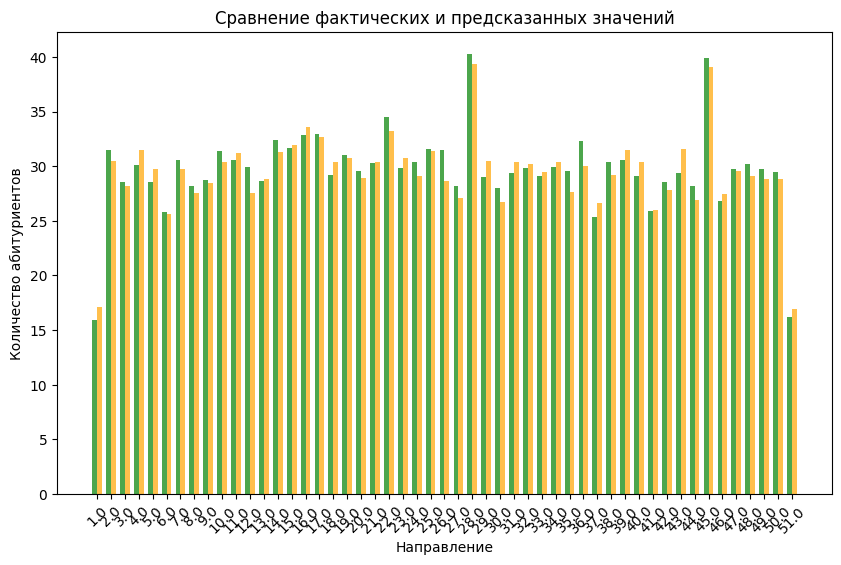

In [27]:
# Группировка данных
mean_values = test_df.groupby('Направление').agg(
    Фактическое_среднее=('Фактическое', 'mean'),
    Предсказанное_среднее=('Предсказанное', 'mean')
).reset_index()

# Построение графика
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(mean_values))

plt.bar(index, mean_values['Фактическое_среднее'], bar_width, label='Фактическое', alpha=0.7, color='green')
plt.bar(index + bar_width, mean_values['Предсказанное_среднее'], bar_width, label='Предсказанное', alpha=0.7, color='orange')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Направление')
plt.ylabel('Количество абитуриентов')
plt.xticks(index + bar_width / 2, mean_values['Направление'], rotation=45)
plt.show()

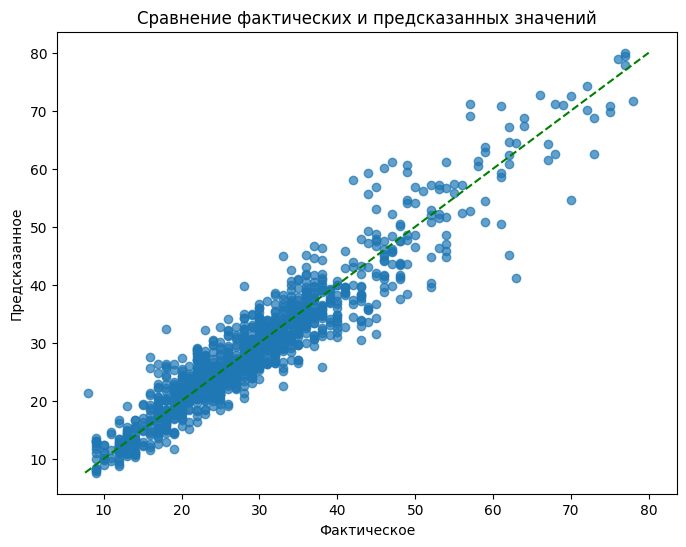

In [28]:
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(test_df['Фактическое'], test_df['Предсказанное'], alpha=0.7)

# Линия идеального соответствия
lims = [np.min([test_df['Фактическое'], test_df['Предсказанное']]),
        np.max([test_df['Фактическое'], test_df['Предсказанное']])]
plt.plot(lims, lims, color='green', linestyle='--')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Фактическое')
plt.ylabel('Предсказанное')
plt.show()

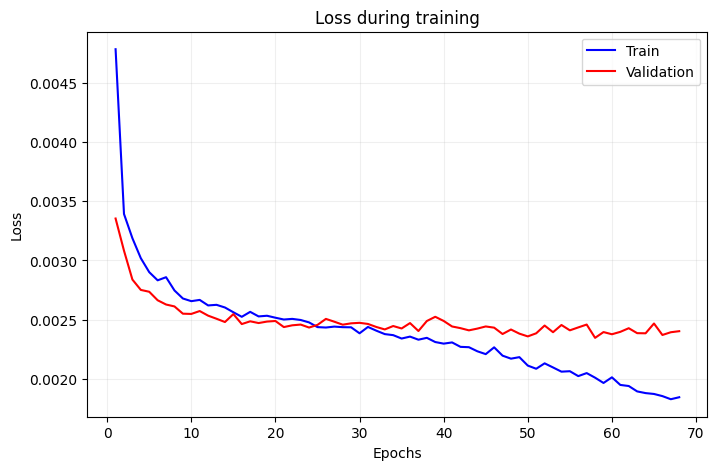

In [29]:
def show_training(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b', label='Train')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

# Вызов функции после обучения модели
show_training(history_lstm)

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Input,  BatchNormalization, Dropout
from keras.utils import to_categorical

# Разделение на признаки и целевую переменную
X = df.drop(columns=['Количество поступивших'])
y = df['Количество поступивших']

# Нормализация целевой переменной
y = np.array(y)
y_scaler = RobustScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели MLP
model_mlp = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])

# Компиляция модели с учетом весов классов
class_weights = {i: 1 / len(df[df['Направление'] == i]) for i in df['Направление'].unique()}
model_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Обучение модели
history_mlp = model_mlp.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,  # Использование весов классов
    verbose=1
)
# Оценка модели
test_loss, test_mae = model_mlp.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 1.0498 - mae: 0.9790 - val_loss: 38.0960 - val_mae: 6.1444
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3922 - mae: 0.7070 - val_loss: 0.6056 - val_mae: 0.6505
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2664 - mae: 0.5939 - val_loss: 0.5308 - val_mae: 0.4960
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1919 - mae: 0.5316 - val_loss: 0.7960 - val_mae: 0.6194
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1423 - mae: 0.5057 - val_loss: 0.7008 - val_mae: 0.6126
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1111 - mae: 0.4715 - val_loss: 0.5663 - val_mae: 0.4929
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1016 - mae: 0.4596 - val_loss: 0.4972 - val_mae: 0.4746
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0968 - mae: 0.4521 - val_loss: 0.7332 - val_mae: 0.6420
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

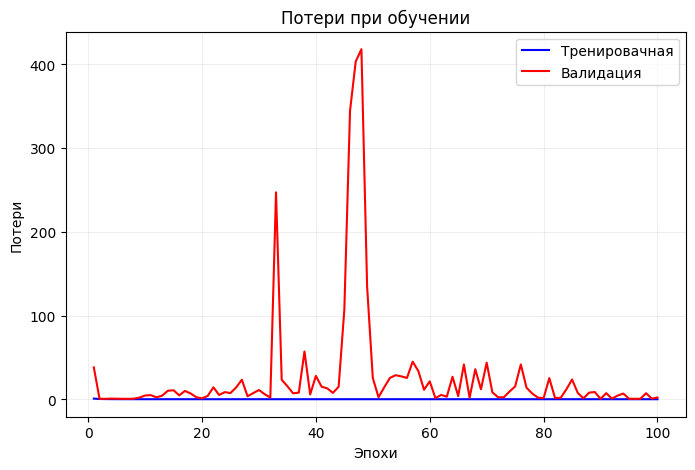

In [14]:
def show_training(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b', label='Тренировачная')
    plt.plot(epochs, val_loss, 'r', label='Валидация')
    plt.title('Потери при обучении')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

# Вызов функции после обучения модели
show_training(history_mlp)

In [15]:
from tensorflow.keras.layers import GRU

# Функция для создания последовательностей данных
def create_sequences(data, window_size):
    inputs, outputs, groups = [], [], []
    for direction in data['Направление'].unique():
        dir_data = data[data['Направление'] == direction].sort_values('Год поступления')
        for i in range(len(dir_data) - window_size):
            seq = dir_data.iloc[i:i+window_size].drop(['Направление', 'Год поступления', 'Количество поступивших'], axis=1).values
            target = dir_data.iloc[i+window_size]['Количество поступивших']
            direction_label = dir_data.iloc[i+window_size]['Направление']  # Направление для следующего шага
            inputs.append(seq)
            outputs.append(target)
            groups.append(direction_label)
    return np.array(inputs), np.array(outputs), np.array(groups)

# Создание последовательностей
YEARS_SIZE = 3
X, y, direction_labels = create_sequences(df, YEARS_SIZE)

# Нормализация целевой переменной
y_scaler = RobustScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test, direction_train, direction_test = train_test_split(
    X, y, direction_labels, test_size=0.2, random_state=42)

# Рассчитываются веса только для тренировочной выборки
unique_directions, direction_counts_train = np.unique(direction_train, return_counts=True)
direction_weights_train = {direction: 1.0 / count for direction, count in zip(unique_directions, direction_counts_train)}

# Применение весов к данным
sample_weights = df['Направление'].map(direction_weights_train).values

# Ограничение веса для тренировочной выборки
train_sample_weights = sample_weights[:len(y_train)]

# Архитектура модели
model_gru = Sequential([
    Input(shape=(YEARS_SIZE, X.shape[2])),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dense(64, activation='relu'),
    Dense(1)
])

# Компиляция модели
model_gru.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Обучение модели
history_gru = model_gru.fit(
    X_train,
    y_train,
    sample_weight=train_sample_weights,  # Использование веса
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Оценка модели на тестовой выборке
test_loss, test_mae = model_gru.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0054 - mae: 0.4904 - val_loss: 0.0039 - val_mae: 0.3597
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0040 - mae: 0.3640 - val_loss: 0.0037 - val_mae: 0.3388
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - mae: 0.3419 - val_loss: 0.0036 - val_mae: 0.3276
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - mae: 0.3263 - val_loss: 0.0034 - val_mae: 0.3107
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - mae: 0.3198 - val_loss: 0.0034 - val_mae: 0.3115
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - mae: 0.3260 - val_loss: 0.0034 - val_mae: 0.3141
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - mae: 0.3240 - val_loss: 0.0033 - val_mae: 0.3010
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - mae: 0.3160 - val_loss: 0.0033 - val_mae: 0.3023
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - 

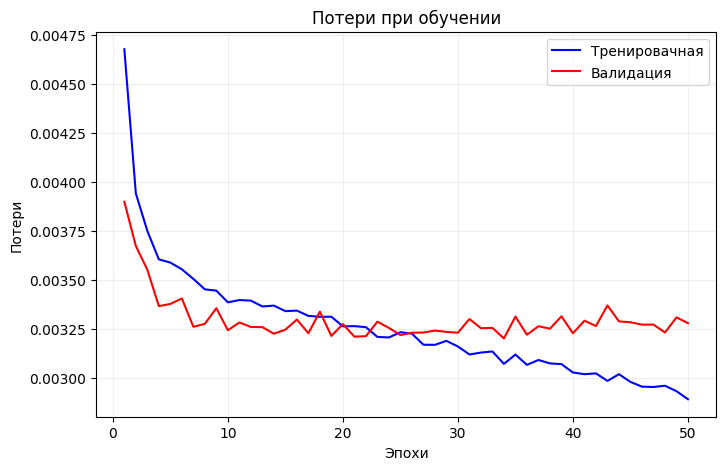

In [16]:
# Вызов функции после обучения модели
show_training(history_gru)

In [17]:
# Предсказание модели
predictions = model_gru.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)  # Обратное преобразование
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Создание DataFrame для анализа
test_df = pd.DataFrame({
    'Направление': direction_test,
    'Фактическое': y_test_original.flatten(),
    'Предсказанное': predictions.flatten()
})

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


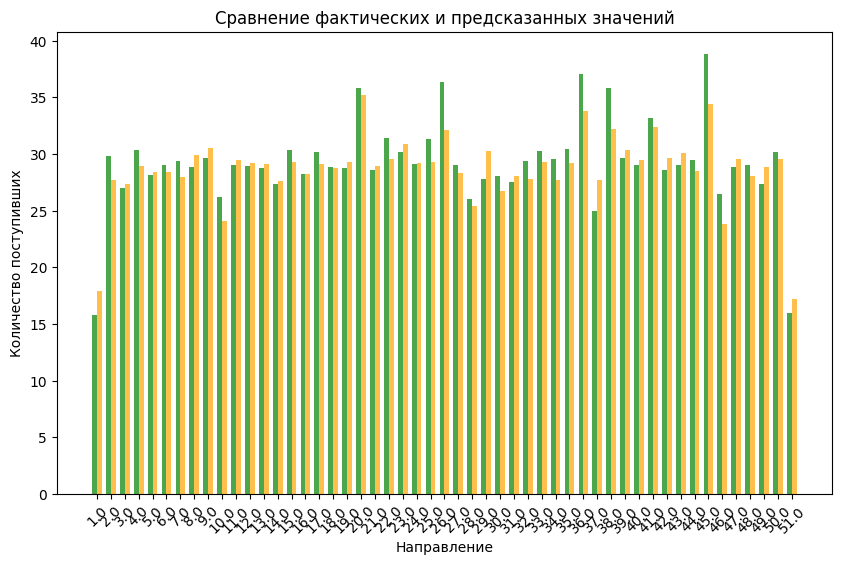

In [18]:
# Группировка данных
mean_values = test_df.groupby('Направление').agg(
    Фактическое_среднее=('Фактическое', 'mean'),
    Предсказанное_среднее=('Предсказанное', 'mean')
).reset_index()

# Построение графика
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(mean_values))

plt.bar(index, mean_values['Фактическое_среднее'], bar_width, label='Фактическое', alpha=0.7, color='green')
plt.bar(index + bar_width, mean_values['Предсказанное_среднее'], bar_width, label='Предсказанное', alpha=0.7, color='orange')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Направление')
plt.ylabel('Количество поступивших')
plt.xticks(index + bar_width / 2, mean_values['Направление'], rotation=45)
plt.show()

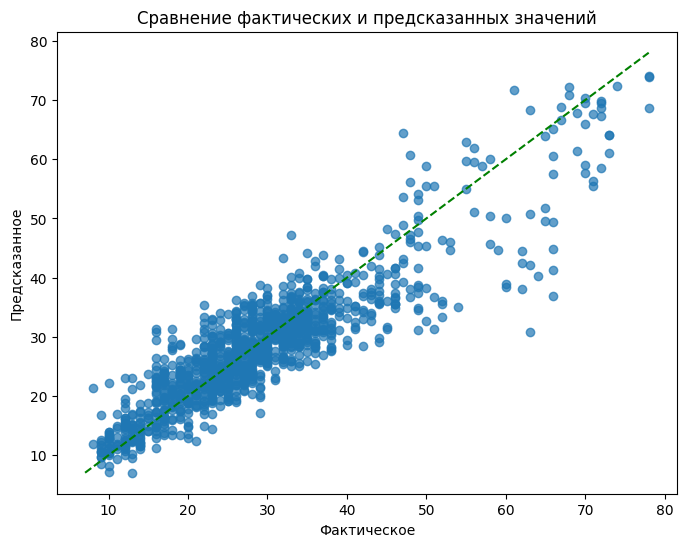

In [19]:
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(test_df['Фактическое'], test_df['Предсказанное'], alpha=0.7)

# Линия идеального соответствия
lims = [np.min([test_df['Фактическое'], test_df['Предсказанное']]),
        np.max([test_df['Фактическое'], test_df['Предсказанное']])]
plt.plot(lims, lims, color='green', linestyle='--')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Фактическое')
plt.ylabel('Предсказанное')
plt.show()